In [196]:
import yfinance as yf
import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import SGDClassifier,ElasticNet

from nonconformist.base import ClassifierAdapter
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory, ClassifierNc, InverseProbabilityErrFunc, MarginErrFunc

# EDA

In [72]:
app_train = pd.read_csv(r'C:\Users\admin\OneDrive\Document\11. Research project\application_train.csv')

In [73]:
# Missing value overview
def missing_columns(dataframe):
    """
    Returns a dataframe that contains missing column names and 
    percent of missing values in relation to the whole dataframe.
    
    dataframe: dataframe that gives the column names and their % of missing values
    """
    
    # find the missing values
    missing_values = dataframe.isnull().sum().sort_values(ascending=False)
    
    # percentage of missing values in relation to the overall size
    missing_values_pct = 100 * missing_values/len(dataframe)
    
    # create a new dataframe which is a concatinated version
    concat_values = pd.concat([missing_values, missing_values/len(dataframe),missing_values_pct.round(1)],axis=1)

    # give new col names
    concat_values.columns = ['Missing Count','Missing Count Ratio','Missing Count %']
    
    # return the required values
    return concat_values[concat_values.iloc[:,1]!=0]
    

In [75]:
missing_train = missing_columns(app_train)
missing_train

,Missing Count,Missing Count Ratio,Missing Count %
COMMONAREA_MEDI,214865,0.698723,69.9
COMMONAREA_AVG,214865,0.698723,69.9
COMMONAREA_MODE,214865,0.698723,69.9
NONLIVINGAPARTMENTS_MODE,213514,0.694330,69.4
NONLIVINGAPARTMENTS_AVG,213514,0.694330,69.4
...,...,...,...
EXT_SOURCE_2,660,0.002146,0.2
AMT_GOODS_PRICE,278,0.000904,0.1
AMT_ANNUITY,12,0.000039,0.0
CNT_FAM_MEMBERS,2,0.000007,0.0


In [76]:
# Having too many NAN. Almost are abt living area, number of elevators, apartment size...
features_not_using = missing_train.index[0:57]
# Inclue occupation_type
features_not_using = features_not_using[features_not_using != 'OCCUPATION_TYPE']
features_not_using

Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE',
       'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE',
       'LANDAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MEDI',
       'ELEVATORS_AVG', 'ELEVATORS_MODE', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE',
       'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_AVG',
       'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE',
       'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATI

In [77]:
app_train_select = app_train.drop(columns=features_not_using)
app_train_select # 66 columns instead of 122

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,0,0,0,0,0,0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
# Deal with missing values for selected df
app_train_select['OCCUPATION_TYPE'].fillna('Laborers',inplace=True) # Mode Value
app_train_select['NAME_TYPE_SUITE'].fillna('Unaccompanied',inplace=True) # Mode Value
app_train_select['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0,inplace=True) # Mode Value
app_train_select['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0,inplace=True) # Mode Value
app_train_select['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0,inplace=True) # Mode Value
app_train_select['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0,inplace=True) # Mode Value
app_train_select.dropna(subset=['EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'], inplace=True) # Drop NAN for the remainings as there are not many NANs

In [14]:
#cat_var = app_train_select.select_dtypes(exclude=['number']).columns.tolist()
#num_var = [e for e in app_train_select.columns if e not in cat_var]

In [79]:
# Encode categorized variables
cat_var = app_train_select.select_dtypes(exclude=['number']).columns.tolist()
cat_var

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [80]:
label_encoder = LabelEncoder()
for i in cat_var:
    app_train_select[i] = label_encoder.fit_transform(app_train_select[i])

In [81]:
stat_df = app_train_select.describe()
stat_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,3.065620e+05,3.065620e+05,306562.000000,...,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000
mean,278178.863039,0.080741,0.094405,0.341908,0.340544,0.693569,0.416963,1.688826e+05,5.995983e+05,27130.182304,...,0.000007,0.003536,0.002946,0.001213,0.009952,0.000267,0.008145,0.000597,0.000509,0.000329
std,102786.281076,0.272437,0.292392,0.474377,0.473893,0.461012,0.722084,2.374456e+05,4.026484e+05,14496.150592,...,0.002554,0.059359,0.054193,0.034814,0.099264,0.016353,0.089882,0.024425,0.022552,0.018148
min,100002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189153.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16561.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278198.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.485000e+05,5.147775e+05,24930.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.750000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34609.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,1.000000,2.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Features Selection

In [314]:
X = app_train_select.drop('TARGET', axis=1)  # Features
y = app_train_select['TARGET']  # Target variable
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)

In [315]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit and transform on the training data
X_train_1 = scaler.fit_transform(X_train_1)
X_test_1 = scaler.transform(X_test_1)

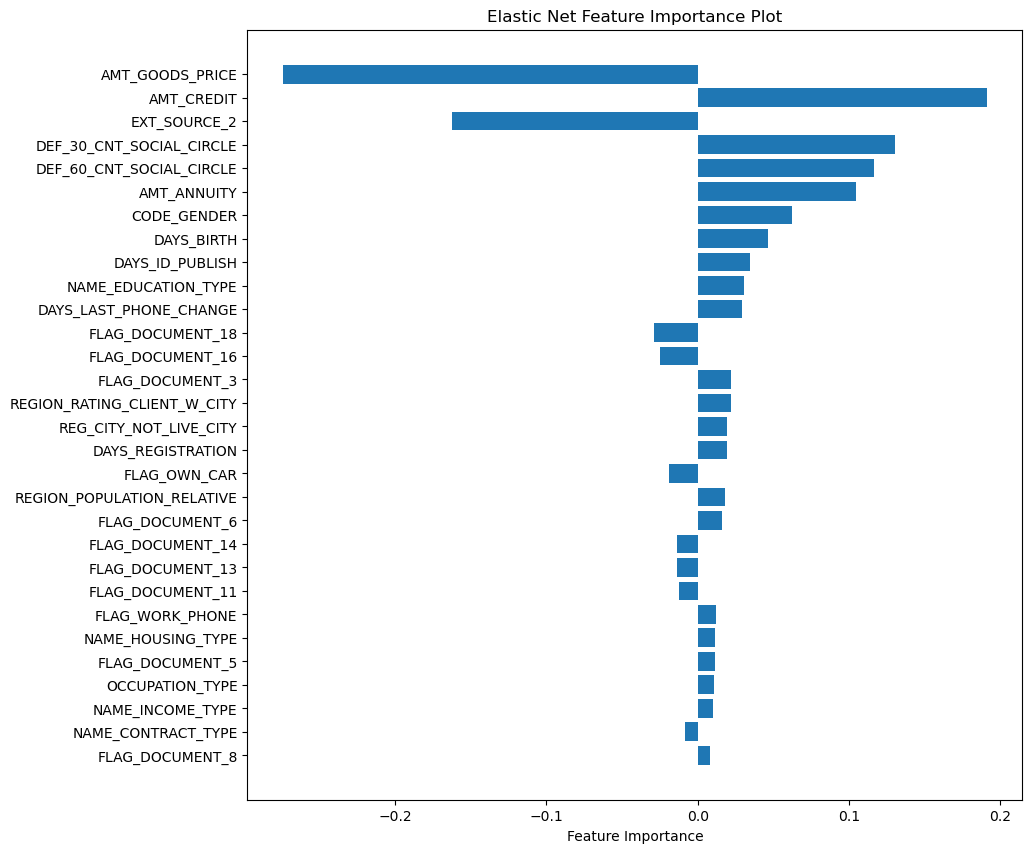

In [316]:
# Create and fit Elastic Net model
elastic_net = ElasticNet(alpha=0.0001, l1_ratio=0.5)
elastic_net.fit(X_train_1, y_train_1)

# Get feature importance
feature_importance = elastic_net.coef_

# Sort features by importance
sorted_features = sorted(zip(X.columns, feature_importance), key=lambda x: abs(x[1]))

# Extract sorted feature names and importance values

sorted_feature_names, sorted_importance = zip(*sorted_features)

# Plotting Feature Importance 
plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_feature_names[-30:])), sorted_importance[-30:])
plt.yticks(range(len(sorted_feature_names[-30:])), sorted_feature_names[-30:])
plt.xlabel('Feature Importance')
plt.title('Elastic Net Feature Importance Plot')
plt.savefig('EN.png', bbox_inches='tight')
plt.show()

In [317]:
important_features_list = list(sorted_feature_names)
selected_feature = important_features_list[-30:]
selected_feature

['FLAG_DOCUMENT_8',
 'NAME_CONTRACT_TYPE',
 'NAME_INCOME_TYPE',
 'OCCUPATION_TYPE',
 'FLAG_DOCUMENT_5',
 'NAME_HOUSING_TYPE',
 'FLAG_WORK_PHONE',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_6',
 'REGION_POPULATION_RELATIVE',
 'FLAG_OWN_CAR',
 'DAYS_REGISTRATION',
 'REG_CITY_NOT_LIVE_CITY',
 'REGION_RATING_CLIENT_W_CITY',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_18',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_EDUCATION_TYPE',
 'DAYS_ID_PUBLISH',
 'DAYS_BIRTH',
 'CODE_GENDER',
 'AMT_ANNUITY',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_2',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE']

In [318]:
X_select = app_train_select[selected_feature]
X_select

,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,FLAG_DOCUMENT_5,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,...,NAME_EDUCATION_TYPE,DAYS_ID_PUBLISH,DAYS_BIRTH,CODE_GENDER,AMT_ANNUITY,DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_CREDIT,AMT_GOODS_PRICE
0,0,0,7,8,0,1,0,0,0,0,...,4,-2120,-9461,1,24700.5,2.0,2.0,0.262949,406597.5,351000.0
1,0,0,4,3,0,1,0,0,0,0,...,1,-291,-16765,0,35698.5,0.0,0.0,0.622246,1293502.5,1129500.0
2,0,1,7,8,0,1,1,0,0,0,...,4,-2531,-19046,1,6750.0,0.0,0.0,0.555912,135000.0,135000.0
3,0,0,7,8,0,1,0,0,0,0,...,4,-2437,-19005,0,29686.5,0.0,0.0,0.650442,312682.5,297000.0
4,1,0,7,3,0,1,0,0,0,0,...,4,-3458,-19932,1,21865.5,0.0,0.0,0.322738,513000.0,513000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,1,0,7,14,0,5,0,0,0,0,...,4,-1982,-9327,1,27558.0,0.0,0.0,0.681632,254700.0,225000.0
307507,0,0,3,8,0,1,0,0,0,0,...,4,-4090,-20775,0,12001.5,0.0,0.0,0.115992,269550.0,225000.0
307508,0,0,7,10,0,1,0,0,0,0,...,1,-5150,-14966,0,29979.0,0.0,0.0,0.535722,677664.0,585000.0
307509,0,0,1,8,0,1,0,0,0,0,...,4,-931,-11961,0,20205.0,0.0,0.0,0.514163,370107.0,319500.0


In [319]:
X_stat = X_select.describe()
X_stat

,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,FLAG_DOCUMENT_5,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,...,NAME_EDUCATION_TYPE,DAYS_ID_PUBLISH,DAYS_BIRTH,CODE_GENDER,AMT_ANNUITY,DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_CREDIT,AMT_GOODS_PRICE
count,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,...,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,306562.000000,3.065620e+05,3.065620e+05,3.065620e+05
mean,0.081497,0.094405,4.669861,7.897062,0.014656,1.290131,0.198899,0.003908,0.003536,0.002946,...,3.188099,-2994.475747,-16037.677736,0.341908,27130.182304,0.099761,0.142982,5.143913e-01,5.995983e+05,5.386689e+05
std,0.273598,0.292392,2.544714,3.646122,0.120172,0.950808,0.399173,0.062391,0.059359,0.054193,...,1.298867,1509.407516,4363.274675,0.474377,14496.150592,0.361824,0.446087,1.910704e-01,4.026484e+05,3.695730e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-7197.000000,-25229.000000,0.000000,1615.500000,0.000000,0.000000,8.170000e-08,4.500000e+04,4.050000e+04
25%,0.000000,0.000000,3.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,-4299.000000,-19681.000000,0.000000,16561.125000,0.000000,0.000000,3.924379e-01,2.700000e+05,2.385000e+05
50%,0.000000,0.000000,7.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,-3255.000000,-15751.000000,0.000000,24930.000000,0.000000,0.000000,5.659722e-01,5.147775e+05,4.500000e+05
75%,0.000000,0.000000,7.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,-1720.000000,-12414.000000,1.000000,34609.500000,0.000000,0.000000,6.636269e-01,8.086500e+05,6.795000e+05
max,1.000000,1.000000,7.000000,17.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,0.000000,-7489.000000,2.000000,258025.500000,24.000000,34.000000,8.549997e-01,4.050000e+06,4.050000e+06


In [320]:
final_df = pd.concat([app_train_select['TARGET'], X_select], axis=1)

# Correlation

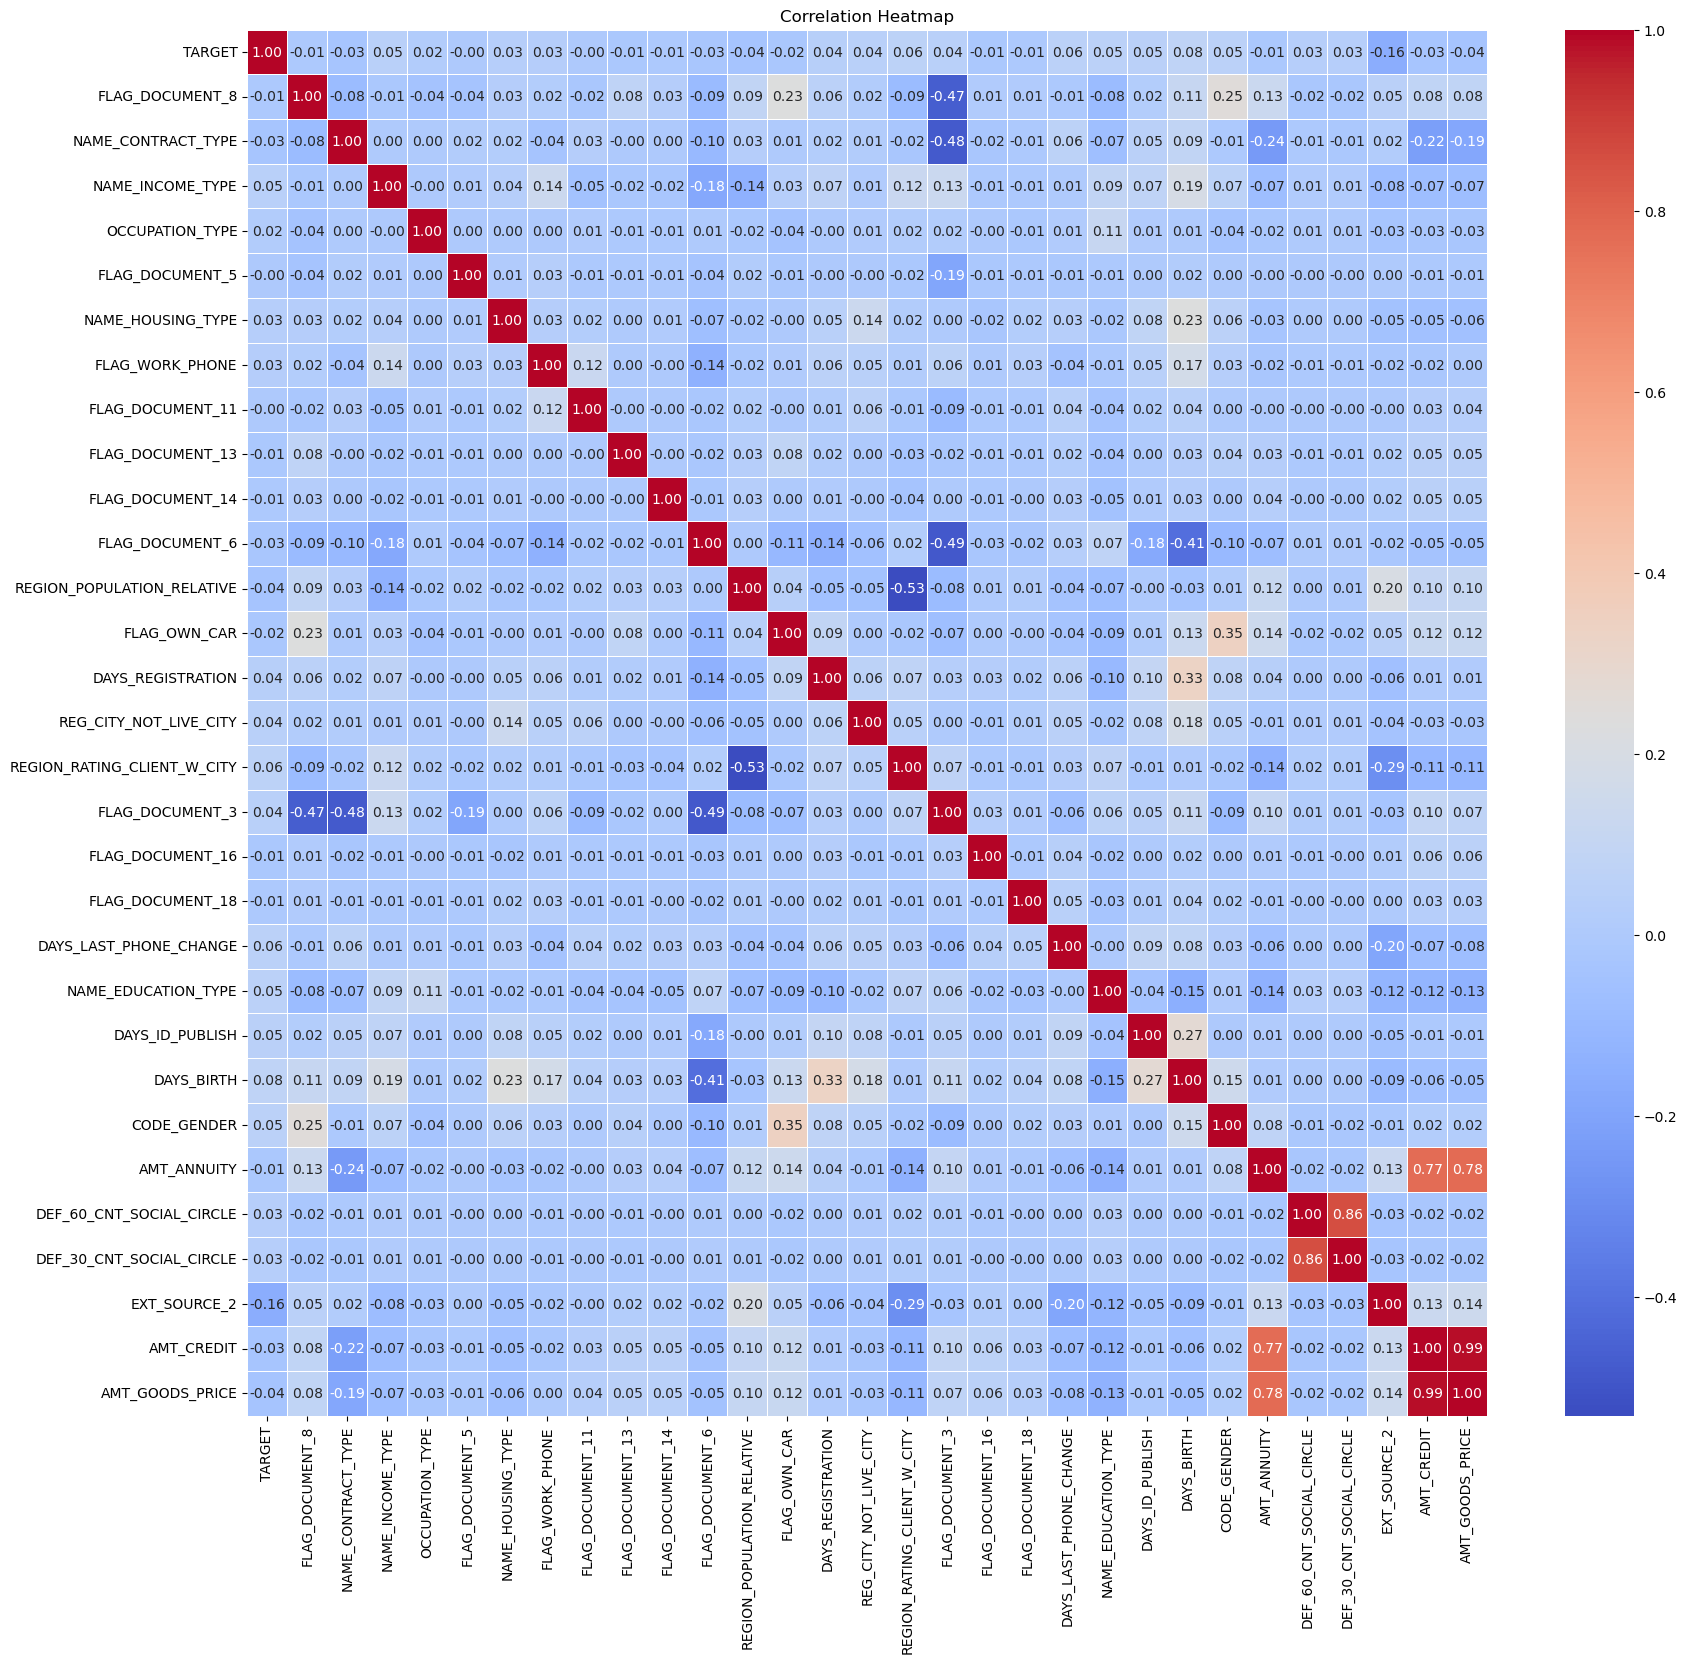

In [103]:
correlation_matrix = final_df.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [321]:
# Drop amt_good_price
final_df = final_df.drop('AMT_GOODS_PRICE', axis=1)

# Outliers

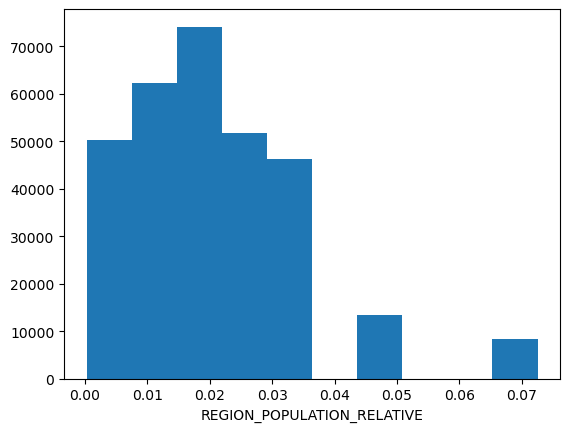

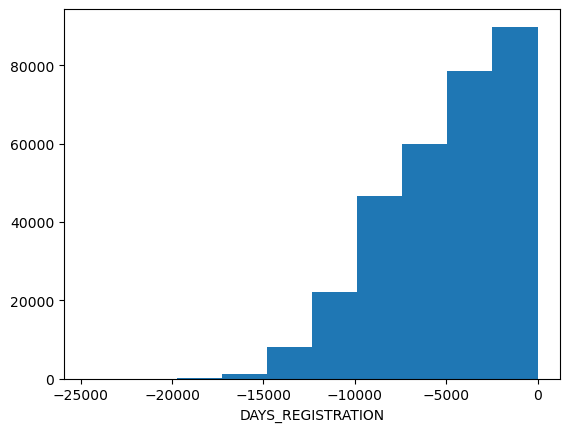

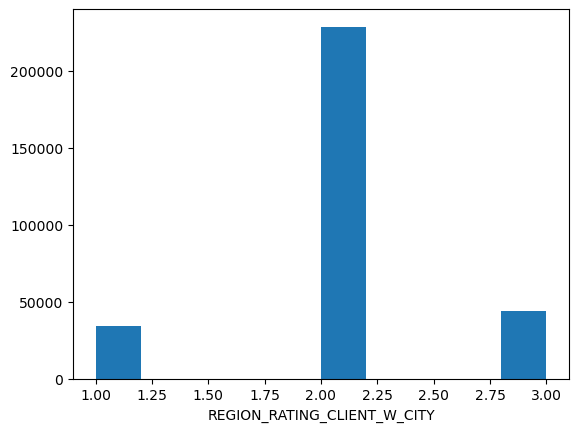

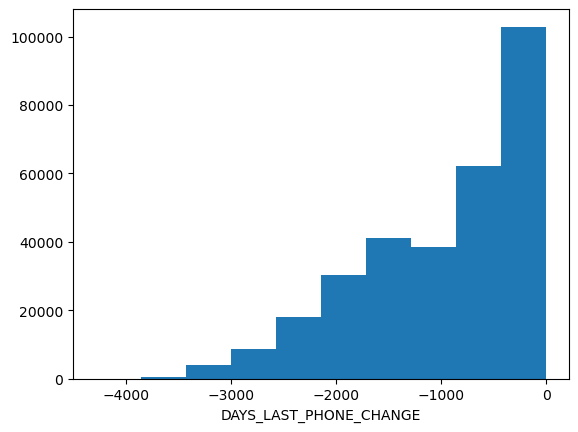

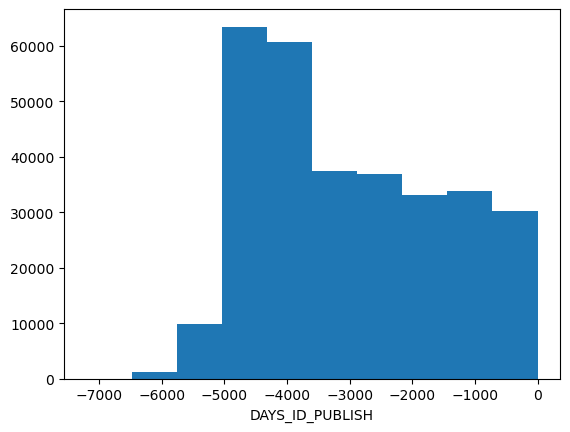

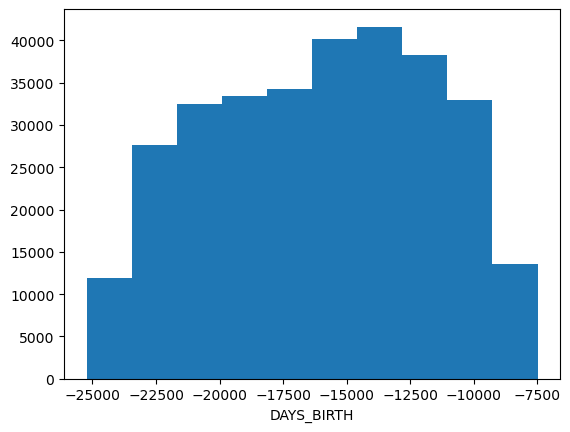

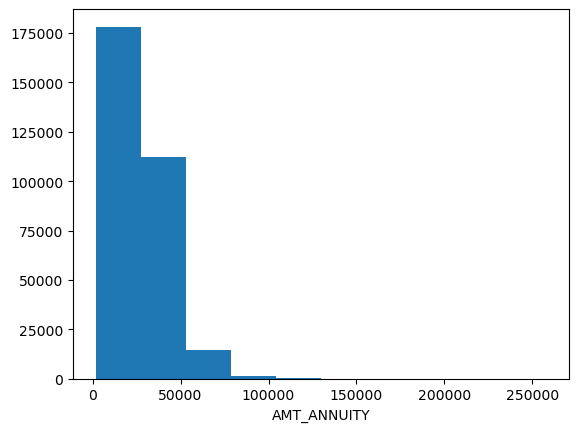

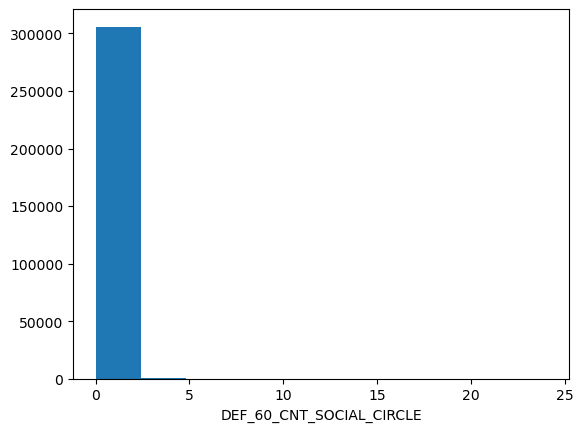

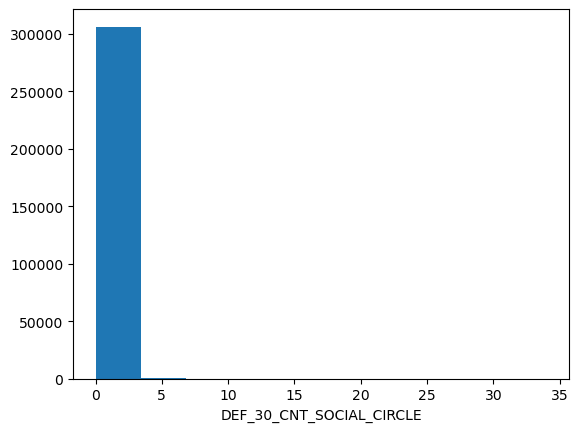

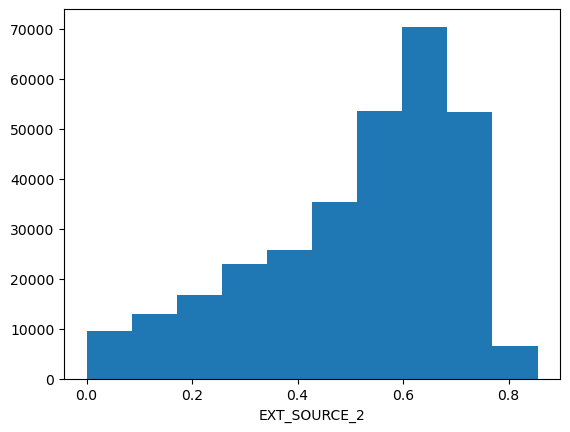

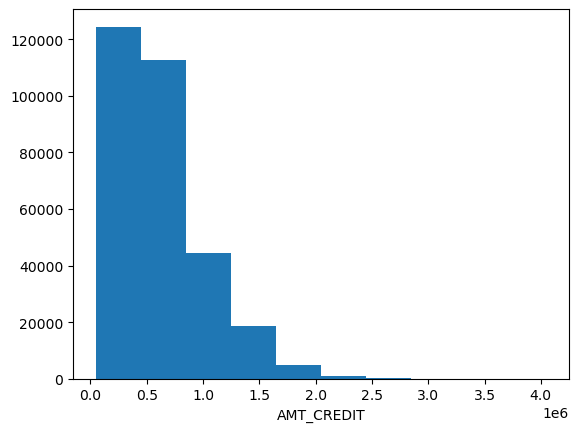

In [322]:
for i in final_df.columns:
    unique_values = final_df[i].unique()
    if i not in cat_var and len(unique_values) > 2:
        plt.hist(final_df[i])
        plt.xlabel(i)
        plt.show()

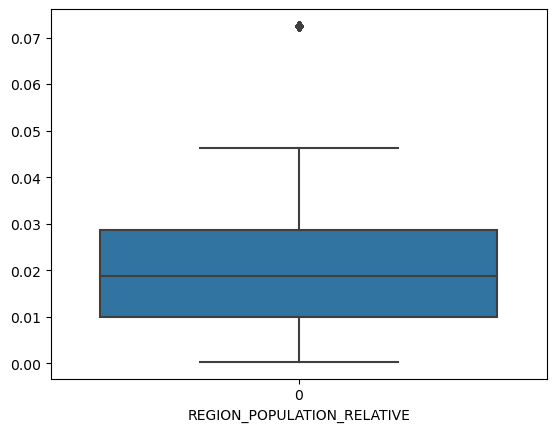

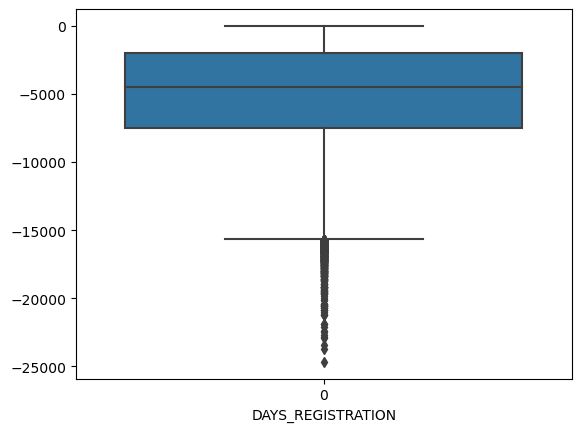

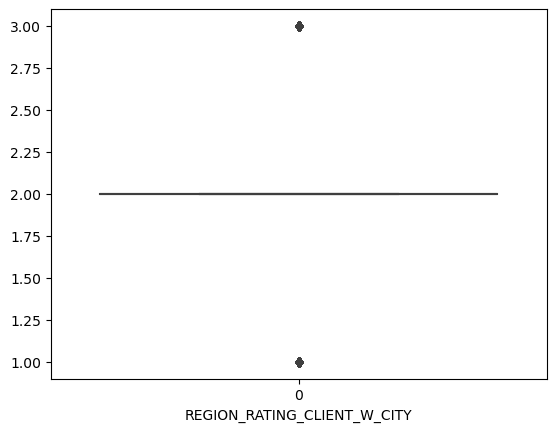

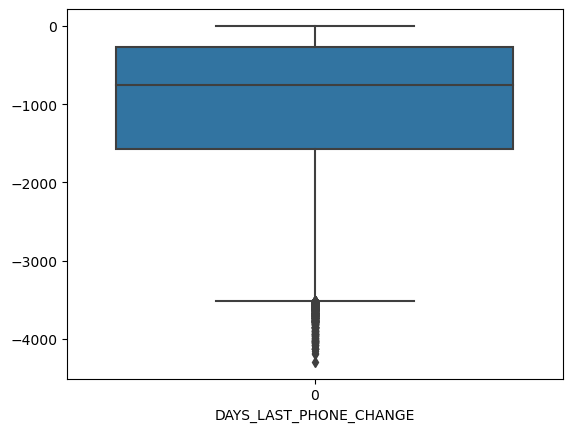

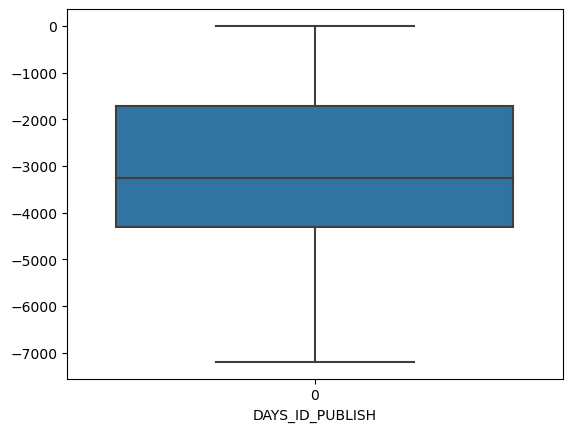

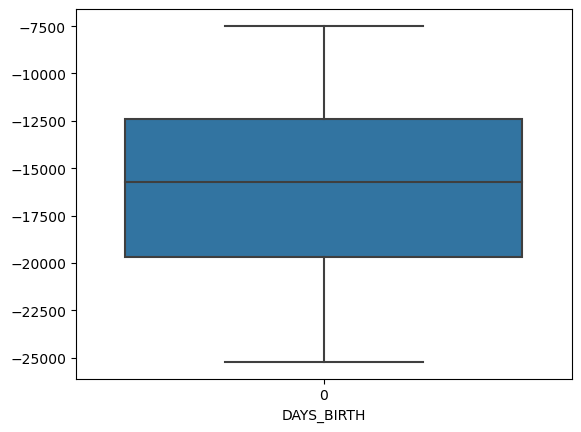

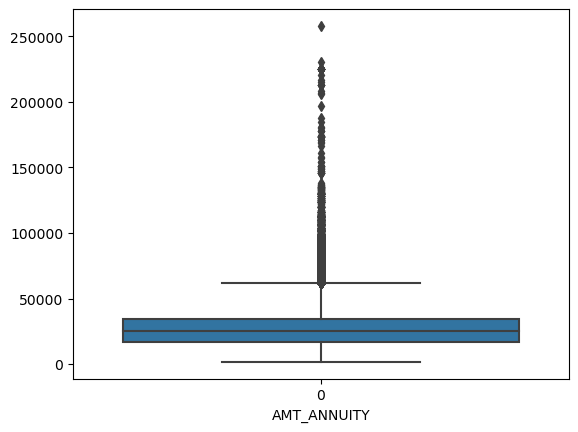

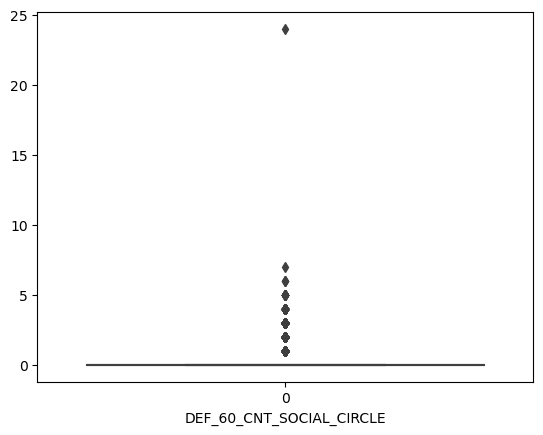

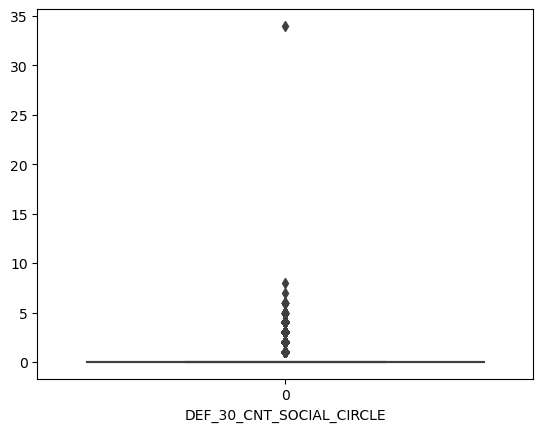

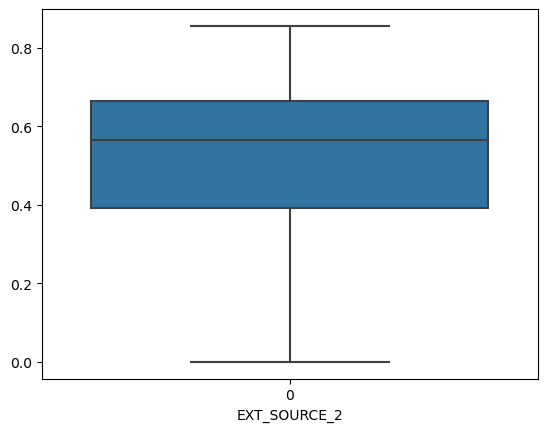

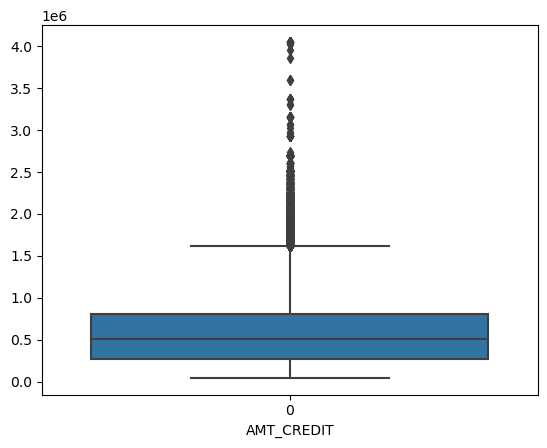

In [323]:
for i in final_df.columns:
    unique_values = final_df[i].unique()
    if i not in cat_var and len(unique_values) > 2:
        sns.boxplot(final_df[i])
        plt.xlabel(i)
        plt.show()

In [324]:
# Outliers
final_df['REGION_POPULATION_RELATIVE'] = mstats.winsorize(final_df['REGION_POPULATION_RELATIVE'], limits=[0.05, 0.05])
final_df['DAYS_REGISTRATION'] = mstats.winsorize(final_df['DAYS_REGISTRATION'], limits=[0.05, 0.05])
final_df['DAYS_LAST_PHONE_CHANGE'] = mstats.winsorize(final_df['DAYS_LAST_PHONE_CHANGE'], limits=[0.05, 0.05])
final_df['AMT_ANNUITY'] = mstats.winsorize(final_df['AMT_ANNUITY'], limits=[0.05, 0.05])
final_df['AMT_CREDIT'] = mstats.winsorize(final_df['AMT_CREDIT'], limits=[0.05, 0.05])

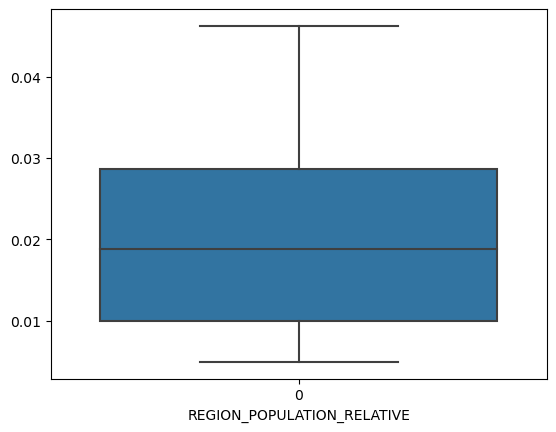

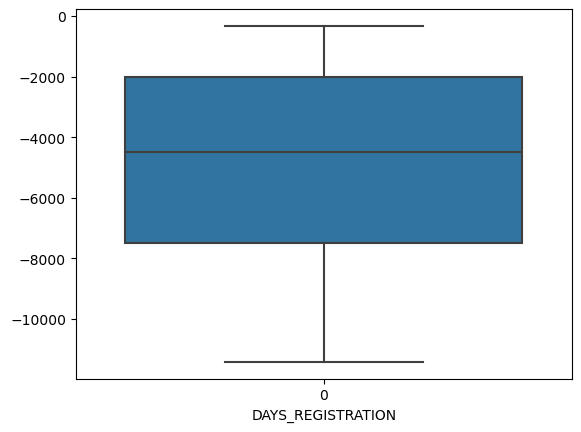

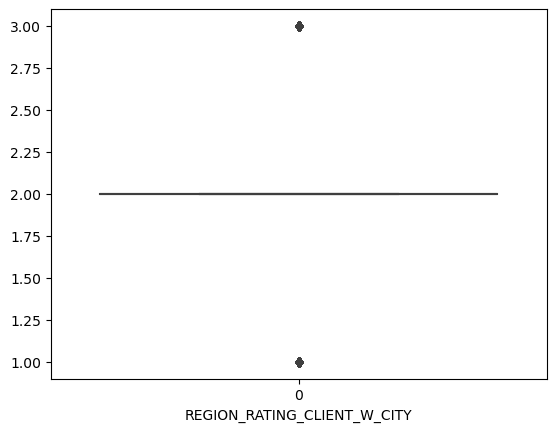

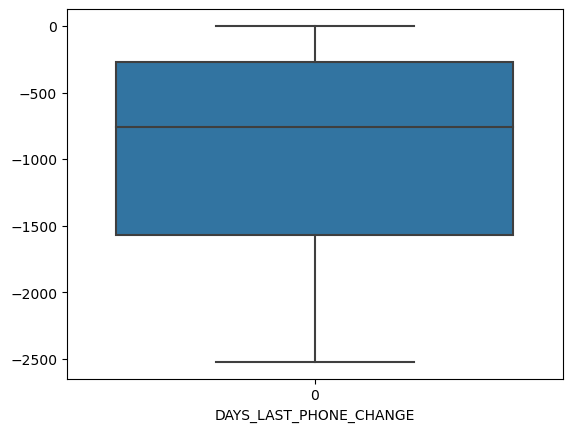

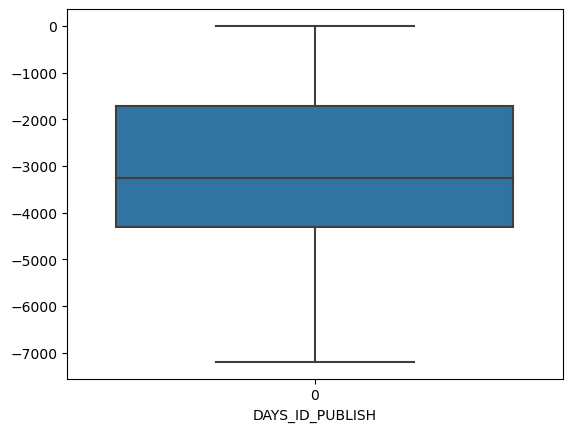

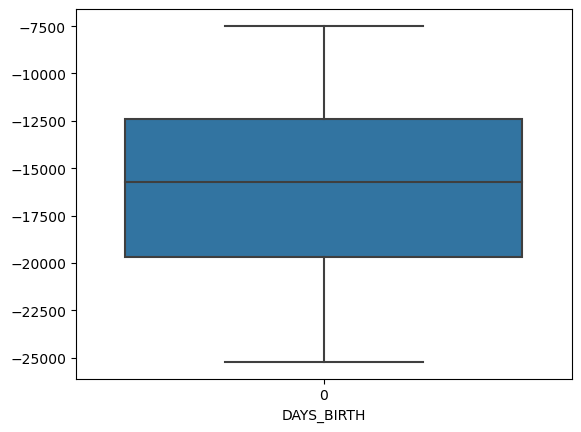

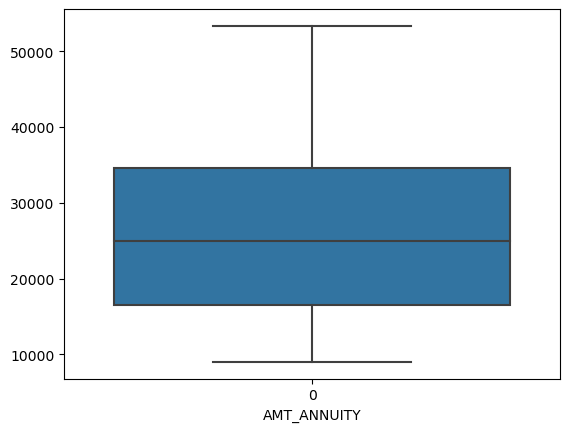

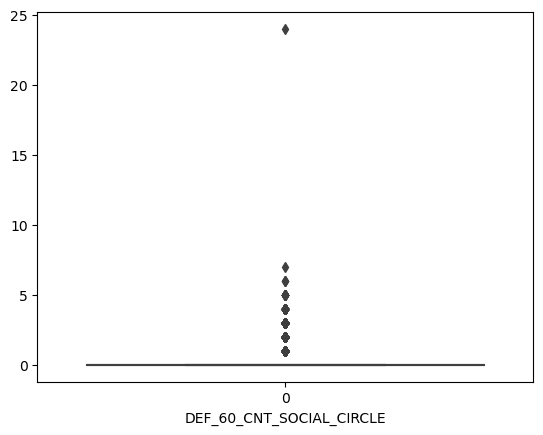

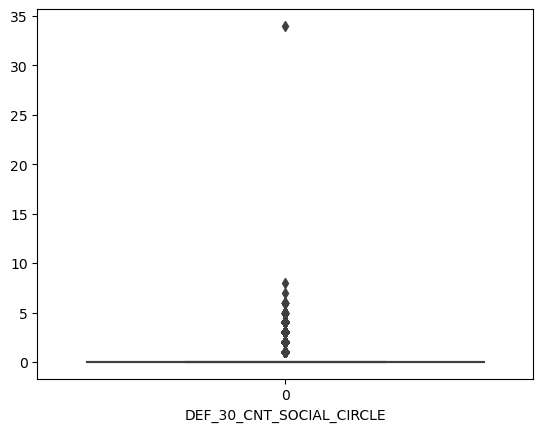

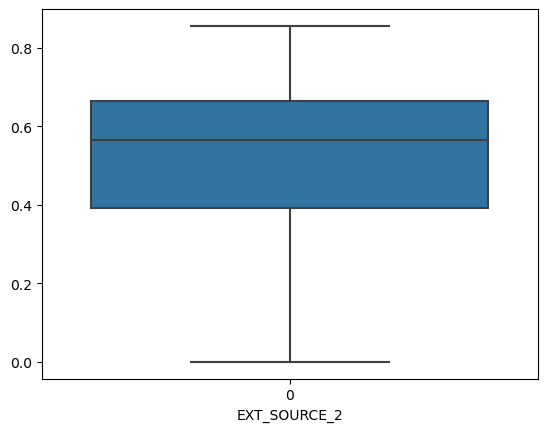

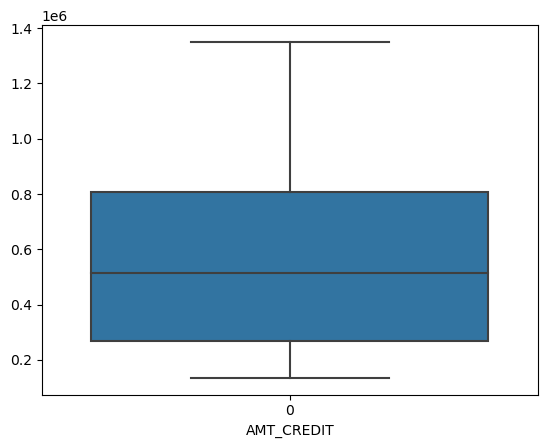

In [126]:
# After winsorizing
for i in final_df.columns:
    unique_values = final_df[i].unique()
    if i not in cat_var and len(unique_values) > 2:
        sns.boxplot(final_df[i])
        plt.xlabel(i)
        plt.show()

In [127]:
final_df.columns

Index(['TARGET', 'FLAG_DOCUMENT_8', 'NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE',
       'OCCUPATION_TYPE', 'FLAG_DOCUMENT_5', 'NAME_HOUSING_TYPE',
       'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_6', 'REGION_POPULATION_RELATIVE',
       'FLAG_OWN_CAR', 'DAYS_REGISTRATION', 'REG_CITY_NOT_LIVE_CITY',
       'REGION_RATING_CLIENT_W_CITY', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_18', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE',
       'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'CODE_GENDER', 'AMT_ANNUITY',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
       'AMT_CREDIT'],
      dtype='object')

# Data Rebalancing

In [325]:
majority_class_label = 0

# Separate majority and minority classes
majority_class = final_df[final_df['TARGET'] == majority_class_label]
minority_class = final_df[final_df['TARGET'] != majority_class_label]

# Randomly undersample the majority class
undersampled_majority_class = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the undersampled majority class with the original minority class
balanced_df = pd.concat([undersampled_majority_class, minority_class])

# Shuffle the DataFrame to mix the samples
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

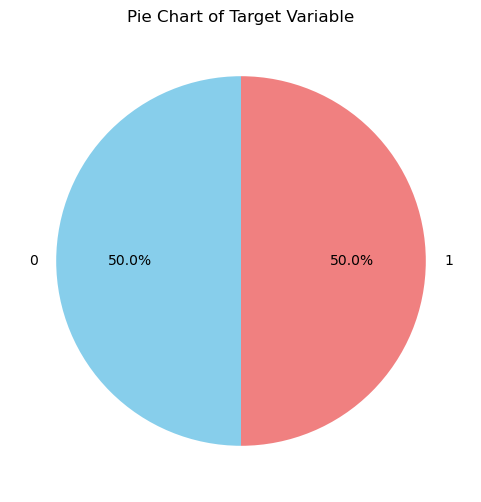

In [326]:
target_counts = balanced_df['TARGET'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Pie Chart of Target Variable')
plt.savefig('TV.png', bbox_inches='tight')
plt.show()

# Point Prediction Model

## Logistic Regression

In [352]:
X_select = balanced_df.drop('TARGET', axis=1)  # Features
y_select = balanced_df['TARGET']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X_select, y_select, test_size=0.2, random_state=42)

In [327]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)

In [328]:
print('Classification accuracy: {}'.format(accuracy_score(y_test, y_pred_lr)))

Classification accuracy: 0.5532774467225533


In [329]:
print('ROC AUC: {}'.format(roc_auc_score(y_test, y_prob_lr[:,1]))) 

ROC AUC: 0.5816484095283361


## XGBoost

In [330]:
xgb_classifier = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [331]:
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
y_prob_xgb = xgb_classifier.predict_proba(X_test)

In [332]:
accuracy = accuracy_score(y_test, y_pred_xgb)

In [333]:
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6536


In [334]:
print('ROC AUC: {}'.format(roc_auc_score(y_test, y_prob_xgb[:,1]))) 

ROC AUC: 0.7069331655550362


## Random Forest

In [335]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
y_prob_rf = rf_classifier.predict_proba(X_test)

In [336]:
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6464


In [337]:
print('ROC AUC: {}'.format(roc_auc_score(y_test, y_prob_rf[:,1]))) 

ROC AUC: 0.6991696516709712


### Tuning the XGB Model

In [338]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; tot

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.0

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200, subsample=0.9; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.0

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.0

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_d

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_d

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.0

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.9s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.0

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.9, learning_rate=0.0

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.9, learning_rate=0.0

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   2.3s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   2.7s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_d

[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_d

[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_d

[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_d

[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_d

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.0

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.0

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.0

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.0

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_d

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_d

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_d

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_d

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_d

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_d

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_d

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_d

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=2)

In [341]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 1.0}


In [353]:
best_xgb_classifier = XGBClassifier(**grid_search.best_params_, random_state=42)
best_xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [354]:
y_pred_xgb_best = best_xgb_classifier.predict(X_test)
y_prob_xgb_best = best_xgb_classifier.predict_proba(X_test)

In [355]:
accuracy = accuracy_score(y_test, y_pred_xgb_best)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6574


In [356]:
print('ROC AUC: {}'.format(roc_auc_score(y_test, y_prob_xgb_best[:,1]))) 

ROC AUC: 0.712796442510335


# Conformal Prediction

### Christoph Molnar

In [360]:
# Split data into proper training set, calibration set, and test set
X_train, X_calib_test, y_train, y_calib_test = train_test_split(X_select, y_select, test_size=0.3, random_state=42)
X_calib, X_test, y_calib, y_test = train_test_split(X_calib_test, y_calib_test, test_size=0.5, random_state=42)

In [361]:
print('Training set size {}'.format(len(y_train)))
print('Calibration set size {}'.format(len(y_calib)))
print('Test set size {}'.format(len(y_test)))

Training set size 34652
Calibration set size 7426
Test set size 7426


In [362]:
# Get predictions for calibration set
y_pred_calib = best_xgb_classifier.predict(X_calib)
y_pred_calib_prob = best_xgb_classifier.predict_proba(X_calib)

In [363]:
class_labels = ['0', '1']
n_classes = 2

In [364]:
si_scores = []
# Loop through all calibration instances
for i, true_class in enumerate(y_calib):
    # Get predicted probability for observed/true class
    predicted_prob = y_pred_prob[i][true_class]
    si_scores.append(1 - predicted_prob)    

# Convert to NumPy array
si_scores = np.array(si_scores)

# Show first 5 instances
si_scores[0:5]

array([0.45500588, 0.3004899 , 0.51296347, 0.90733967, 0.52409911])

In [365]:
number_of_samples = len(X_calib)
alpha = 0.05
qlevel = (1 - alpha) * ((number_of_samples + 1) / number_of_samples)
threshold = np.percentile(si_scores, qlevel*100)
print(f'Threshold: {threshold:0.3f}')

Threshold: 0.722


In [366]:
prediction_set_Molnar = (1 - best_xgb_classifier.predict_proba(X_test) <= threshold)
# Show first ten instances
prediction_set_Molnar[0:5]

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True, False]])

In [367]:
y_pred_test = best_xgb_classifier.predict(X_test)
y_pred_test_prob = best_xgb_classifier.predict_proba(X_test)

In [368]:
y_pred_test_prob

array([[0.61983514, 0.38016483],
       [0.30940092, 0.6905991 ],
       [0.5504923 , 0.44950768],
       ...,
       [0.4083237 , 0.5916763 ],
       [0.31410062, 0.6858994 ],
       [0.41119552, 0.5888045 ]], dtype=float32)

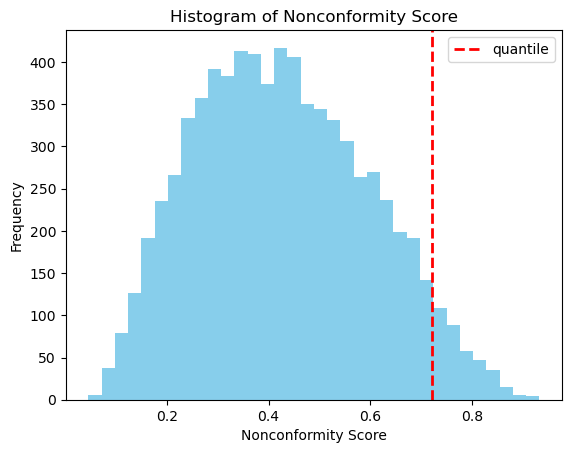

In [369]:
# Plot the histogram
plt.hist(si_scores, bins='auto', color='skyblue')

# Add a vertical line for the
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='quantile')

plt.legend()
plt.xlabel('Nonconformity Score')
plt.ylabel('Frequency')
plt.title('Histogram of Nonconformity Score')

plt.show()

In [370]:
# Get class counts
def get_class_counts(y_test):
    class_counts = []
    for i in range(n_classes):
        class_counts.append(np.sum(y_test == i))
    return class_counts

# Get coverage for each class
def get_coverage_by_class(prediction_sets, y_test):
    coverage = []
    for i in range(n_classes):
        coverage.append(np.mean(prediction_sets[y_test == i, i]))
    return coverage

# Get average set size for each class
def get_average_set_size(prediction_sets, y_test):
    average_set_size = []
    for i in range(n_classes):
        average_set_size.append(
            np.mean(np.sum(prediction_sets[y_test == i], axis=1)))
    return average_set_size     

# Get weighted coverage (weighted by class size)
def get_weighted_coverage(coverage, class_counts):
    total_counts = np.sum(class_counts)
    weighted_coverage = np.sum((coverage * class_counts) / total_counts)
    weighted_coverage = round(weighted_coverage, 3)
    return weighted_coverage

# Get weighted set_size (weighted by class size)
def get_weighted_set_size(set_size, class_counts):
    total_counts = np.sum(class_counts)
    weighted_set_size = np.sum((set_size * class_counts) / total_counts)
    weighted_set_size = round(weighted_set_size, 3)
    return weighted_set_size

In [371]:
result_Molnar = pd.DataFrame(index=class_labels)
result_Molnar['Class counts'] = get_class_counts(y_test)
result_Molnar['Coverage'] = get_coverage_by_class(np.array(prediction_set_Molnar), y_test)
result_Molnar['Average set size'] = get_average_set_size(np.array(prediction_set_Molnar), y_test)
result_Molnar

,Class counts,Coverage,Average set size
0,3705,0.952227,1.758704
1,3721,0.950013,1.745230


In [372]:
def get_prediction_set_labels(prediction_set, class_labels):
    # Get set of class labels for each instance in prediction sets
    prediction_set_labels = [
        set([class_labels[i] for i, x in enumerate(prediction_set) if x]) for prediction_set in 
        prediction_set]
    return prediction_set_labels

In [380]:
# Collate predictions

results_sets_Molnar = pd.DataFrame()
results_sets_Molnar['observed'] = [class_labels[i] for i in y_test]
results_sets_Molnar['labels'] = get_prediction_set_labels(prediction_set_Molnar, class_labels)
results_sets_Molnar['classifications'] = [class_labels[i] for i in y_pred_test]

# Show first 10 results
results_sets_Molnar.head(10)

,observed,labels,classifications
0,1,"{1, 0}",0
1,1,"{1, 0}",1
2,1,"{1, 0}",0
3,1,"{1, 0}",1
4,0,{0},0
5,0,{0},0
6,1,{1},1
7,0,{1},1
8,0,"{1, 0}",0
9,1,{0},0


In [377]:
value_counts_Molnar = results_sets_Molnar['labels'].value_counts()
value_counts_Molnar_df = pd.DataFrame(value_counts_Molnar)
value_counts_Molnar_df

,labels
"{1, 0}",5584
{1},939
{0},903


In [379]:
CE_Molnar = (value_counts_Molnar_df.iloc[1,0] + value_counts_Molnar_df.iloc[2,0]) / results_sets_Molnar.shape[0]
CE_Molnar

0.24804740102343117

### Vovk et al. (2005) & Vovk et al. (2008)

In [204]:
def InverseProbabilityNC(predicted_score, y):
  prob = np.zeros(y.size, dtype=np.float32)
  for i, y_ in enumerate(y):
    if y_ >= predicted_score.shape[1]:
      prob[i] = 0
    else:
      prob[i] = predicted_score[i, int(y_)]
  return 1 - prob

In [202]:
def compute_p_values(non_conformity_scores_calibration, non_conformity_scores_test):
  p_values = []
  if not isinstance(non_conformity_scores_test, list):
    non_conformity_scores_test = [non_conformity_scores_test]

  for i, test_point_conformity_score in enumerate(non_conformity_scores_test):
    p_value = (np.sum(non_conformity_scores_calibration >= test_point_conformity_score) + 1) / (len(non_conformity_scores_calibration)+1)
    p_values.append(p_value)
  return np.array(p_values)

In [203]:
y_pred_score_calib = best_xgb_classifier.predict_proba(X_calib)
y_pred_score_test = best_xgb_classifier.predict_proba(X_test)

In [205]:
non_conformity_scores_calibration = InverseProbabilityNC(y_pred_score_calib,y_calib)

In [206]:
non_conformity_scores_y_test_class_0 = 1 - y_pred_score_test[:,0]
non_conformity_scores_y_test_class_1 = 1 - y_pred_score_test[:,1]

In [207]:
non_conformity_scores_calib_plus_test_0 = np.append(non_conformity_scores_calibration, non_conformity_scores_y_test_class_0)
non_conformity_scores_calib_plus_test_1 = np.append(non_conformity_scores_calibration, non_conformity_scores_y_test_class_1)

In [209]:
# Function computes prediction sets - here we essentially collect all the steps done above into one function
# Function takes training set, test points, underlying classifier, significance level
# Function returns for each test point, prediction sets and two sets of p-values for each potential label 0 & 1

def prediction_sets(X_train, y_train, X_calib, y_calib, X_test, y_test, model = XGBClassifier(**grid_search.best_params_, random_state=42) , significance_level = 0.05):

  prediction_sets = []
  p_values_class_0 = []
  p_values_class_1 = []

  model.fit(X_train, y_train)

  # make point predictions and obtain class scores on the calibration and test sets
  y_pred_calib = model.predict(X_calib)
  y_pred_score_calib = model.predict_proba(X_calib)

  y_pred_test = model.predict(X_test)
  y_pred_score_test = model.predict_proba(X_test)

  for i,y in enumerate(y_test):
        # compute nonconformity scores for each test trying both potential labels - 0 & 1
        non_conformity_scores_y_test_class_0 = 1 - y_pred_score_test[i,0]
        non_conformity_scores_y_test_class_1 = 1 - y_pred_score_test[i,1]

        # compute p-value of the test point twice, each time assigning potential label 0 and 1
        p_value_class_0 = compute_p_values(non_conformity_scores_calib_plus_test_0, non_conformity_scores_y_test_class_0)
        p_value_class_1 = compute_p_values(non_conformity_scores_calib_plus_test_0, non_conformity_scores_y_test_class_1)

        p_values_class_0.append( p_value_class_0)
        p_values_class_1.append( p_value_class_1)

        if (p_value_class_0 > significance_level) and (p_value_class_1 > significance_level):
          prediction_sets.append([True,True])
        elif (p_value_class_0 > significance_level) and (p_value_class_1 <= significance_level):
          prediction_sets.append([True,False])
        elif (p_value_class_0 <= significance_level) and (p_value_class_1 >significance_level):
          prediction_sets.append([False,True])
        else:
          prediction_sets.append([False,False])

  return prediction_sets, p_values_class_0, p_values_class_1

In [210]:
prediction_set_Vovk, p_values_test_set_class_0, p_values_test_set_class_1 = prediction_sets(X_train, y_train, X_calib, y_calib, X_test, y_test, model = XGBClassifier(**grid_search.best_params_, random_state=42), significance_level = 0.05)

In [211]:
prediction_set_Vovk[0:10]

[[True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, False],
 [True, True],
 [False, True],
 [False, True],
 [True, True],
 [True, False]]

In [212]:
result_Vovk = pd.DataFrame(index=class_labels)
result_Vovk['Class counts'] = get_class_counts(y_test)
result_Vovk['Coverage'] = get_coverage_by_class(np.array(prediction_set_Vovk), y_test)
result_Vovk['Average set size'] = get_average_set_size(np.array(prediction_set_Vovk), y_test)
result_Vovk

,Class counts,Coverage,Average set size
0,3705,0.971930,1.858570
1,3721,0.977694,1.853803


In [213]:
# Collate predictions

results_sets_Vovk = pd.DataFrame()
results_sets_Vovk['observed'] = [class_labels[i] for i in y_test]
results_sets_Vovk['labels'] = get_prediction_set_labels(prediction_set_Vovk, class_labels)
results_sets_Vovk['classifications'] = [class_labels[i] for i in y_pred]

# Show first 10 results
results_sets_Vovk.head(5)

,observed,labels,classifications
0,1,"{1, 0}",0
1,1,"{1, 0}",0
2,1,"{1, 0}",1
3,1,"{1, 0}",0
4,0,{0},1


In [214]:
value_counts_Vovk = results_sets_Vovk['labels'].value_counts()
value_counts_Vovk_df = pd.DataFrame(value_counts_Vovk)
value_counts_Vovk_df

,labels
"{1, 0}",6358
{1},565
{0},503


In [215]:
CE_Vovk = (value_counts_Vovk_df.iloc[1,0] + value_counts_Vovk_df.iloc[2,0]) / results_sets_Vovk.shape[0]
CE_Vovk

0.14381901427417182

### More Visualization

#### Vovk

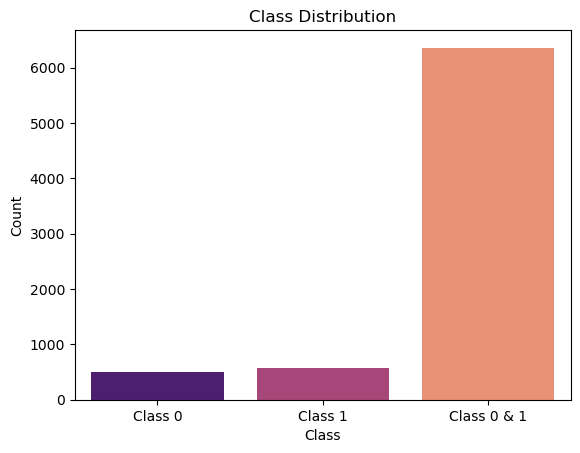

In [256]:
class_labels = ['Class 0', 'Class 1', 'Class 0 & 1']
class_counts = [503, 565, 6358]


#sns.barplot(x=class_labels + true_labels, y=class_counts + true_counts, palette='magma')
sns.barplot(x=class_labels, y=class_counts, palette='magma')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

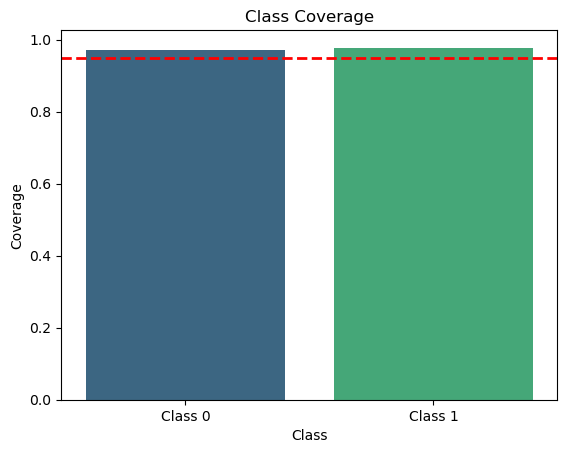

In [252]:
class_labels = ['Class 0', 'Class 1']
class_counts = [result_Vovk.iloc[0,1], result_Vovk.iloc[1,1]]

sns.barplot(x=class_labels, y=class_counts, palette='viridis')
plt.axhline(0.95, color='red', linestyle='dashed', linewidth=2, label='Minimum Coverage')
plt.xlabel('Class')
plt.ylabel('Coverage')
plt.title('Class Coverage')
plt.show()

#### Molnar